In [40]:
import findspark
findspark.init()

In [41]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import *

from pyspark.sql.functions import col

In [43]:
%cd "C:\Users\khaih\Downloads\GUI_Project_3\Data"

C:\Users\khaih\Downloads\GUI_Project_3\Data


In [44]:
spark = SparkSession.builder.appName('KMeans_RFM').getOrCreate()

In [45]:
data = spark.read.csv("RFM_data.csv", header=True,
                      inferSchema=True)

In [46]:
data.show(3)

+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+
|customer_id|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|RFM_Level|
+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+
|       7592|      1|      201|13990.93|  4|  4|  4|        444|       12|    STARS|
|      14048|      0|      217| 8976.33|  4|  4|  4|        444|       12|    STARS|
|       7983|      5|      149| 6973.07|  4|  4|  4|        444|       12|    STARS|
+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+
only showing top 3 rows



In [47]:
data=data.filter(col("Monetary")>0)

In [48]:
data.count()

23502

In [49]:
data.dropna().count()

23502

In [50]:
vec_assembler = VectorAssembler(inputCols = ["Recency","Frequency","Monetary"], outputCol='features')

In [51]:
final_data = vec_assembler.transform(data)

In [52]:
final_data.show(3)

+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+
|customer_id|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|RFM_Level|            features|
+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+
|       7592|      1|      201|13990.93|  4|  4|  4|        444|       12|    STARS|[1.0,201.0,13990.93]|
|      14048|      0|      217| 8976.33|  4|  4|  4|        444|       12|    STARS| [0.0,217.0,8976.33]|
|       7983|      5|      149| 6973.07|  4|  4|  4|        444|       12|    STARS| [5.0,149.0,6973.07]|
+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+
only showing top 3 rows



## Chuẩn hoá dữ liệu trước khi chạy Kmeans

In [53]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [54]:
ScalerModel=scaler.fit(final_data)

In [55]:
final_data =ScalerModel.transform(final_data)

In [56]:
final_data.show(3, truncate=True)

+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+--------------------+
|customer_id|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|RFM_Level|            features|      scaledFeatures|
+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+--------------------+
|       7592|      1|      201|13990.93|  4|  4|  4|        444|       12|    STARS|[1.0,201.0,13990.93]|[0.00551544588297...|
|      14048|      0|      217| 8976.33|  4|  4|  4|        444|       12|    STARS| [0.0,217.0,8976.33]|[0.0,45.761555134...|
|       7983|      5|      149| 6973.07|  4|  4|  4|        444|       12|    STARS| [5.0,149.0,6973.07]|[0.02757722941486...|
+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+--------------------+
only showing top 3 rows



## Chạy model Kmeans

In [57]:
k_list = []
silhouette_list = []
sil_str= ""
for k in range(2,11):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(final_data)
    k_list.append(k)

  #silhouette
    predictions = model.transform(final_data)

  #evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

    sil_str = sil_str + "With k = " +str(k) +" - Silhouette = " +str(silhouette) + "\n"

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

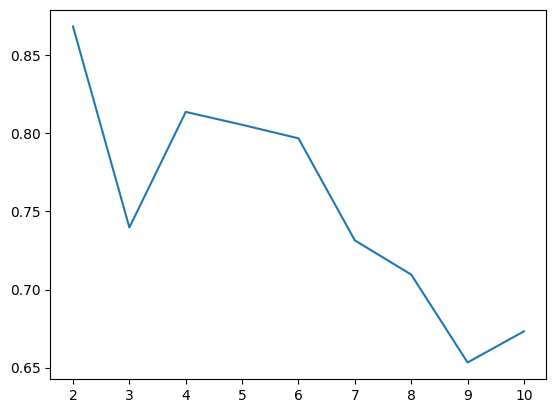

In [59]:
plt.plot(k_list, silhouette_list)
plt.show()

In [60]:
print(sil_str)

With k = 2 - Silhouette = 0.8685305027547384
With k = 3 - Silhouette = 0.7397389715190009
With k = 4 - Silhouette = 0.8137865668149391
With k = 5 - Silhouette = 0.8055564397116455
With k = 6 - Silhouette = 0.7968703013278218
With k = 7 - Silhouette = 0.7314719587949762
With k = 8 - Silhouette = 0.7095913963541428
With k = 9 - Silhouette = 0.6532583900339455
With k = 10 - Silhouette = 0.673197290021912



### Chọn k=5 để chạy model

In [61]:
kmeans = KMeans(featuresCol='scaledFeatures', k=5)
model = kmeans.fit(final_data)

In [62]:
predictions = model.transform(final_data)

  #evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette = ", str(silhouette))

Silhouette =  0.8055564397116455


In [63]:
#Show result
centers = model.clusterCenters()
print("Cluster Center: ")
for center in centers:
  print(center)

Cluster Center: 
[2.67737942 0.28792341 0.17663861]
[ 0.33713163 27.81016167 28.80346658]
[0.40795216 2.51013414 2.06597859]
[0.78192983 0.86031936 0.53738492]
[0.24745708 6.53736502 7.07977279]


In [64]:
predictions = model.transform(final_data)

In [65]:
predictions.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    8|
|         3| 6190|
|         4|  139|
|         2| 1441|
|         0|15724|
+----------+-----+



In [26]:
from pyspark.ml.functions import *

In [28]:
temp = final_data.select("features").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [29]:
temp.show(3)

+---+-----+--------+
| _1|   _2|      _3|
+---+-----+--------+
|1.0|201.0|13990.93|
|0.0|217.0| 8976.33|
|5.0|149.0| 6973.07|
+---+-----+--------+
only showing top 3 rows



In [30]:
temp= temp.select(col('_1').alias('x_scale'), col('_2').alias('y_scale'), col('_3').alias('z_scale'))

In [31]:
temp.show(3)

+-------+-------+--------+
|x_scale|y_scale| z_scale|
+-------+-------+--------+
|    1.0|  201.0|13990.93|
|    0.0|  217.0| 8976.33|
|    5.0|  149.0| 6973.07|
+-------+-------+--------+
only showing top 3 rows



In [32]:
from pyspark.sql.functions import monotonically_increasing_id as mi
#combined temp to final
final_data=final_data.withColumn('row_index', mi())
temp=temp.withColumn('row_index', mi())
final_data = final_data.join(temp, on=['row_index']).sort('row_index')

data_result = predictions.select('prediction')
data_result = data_result.withColumn('row_index', mi())
final_data = final_data.join(data_result, on=['row_index']).sort('row_index').drop('row_index')

In [33]:
final_data.show(3)

+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+--------------------+-------+-------+--------+----------+
|customer_id|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|RFM_Level|            features|      scaledFeatures|x_scale|y_scale| z_scale|prediction|
+-----------+-------+---------+--------+---+---+---+-----------+---------+---------+--------------------+--------------------+-------+-------+--------+----------+
|       7592|      1|      201|13990.93|  4|  4|  4|        444|       12|    STARS|[1.0,201.0,13990.93]|[0.00551544588297...|    1.0|  201.0|13990.93|         1|
|      14048|      0|      217| 8976.33|  4|  4|  4|        444|       12|    STARS| [0.0,217.0,8976.33]|[0.0,45.761555134...|    0.0|  217.0| 8976.33|         1|
|       7983|      5|      149| 6973.07|  4|  4|  4|        444|       12|    STARS| [5.0,149.0,6973.07]|[0.02757722941486...|    5.0|  149.0| 6973.07|         1|
+-----------+-------+-

In [34]:
df = final_data[['x_scale', 'y_scale', 'z_scale', 'prediction']].toPandas()

In [35]:
center_df = pd.DataFrame(centers)
center_df = center_df.rename(columns={0: 'x_center', 1: 'y_center', 2: 'z_center'})
center_df.head()

,x_center,y_center,z_center
0,2.677379,0.287923,0.176639
1,0.337132,27.810162,28.803467
2,0.407952,2.510134,2.065979
3,0.781930,0.860319,0.537385
4,0.247457,6.537365,7.079773


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

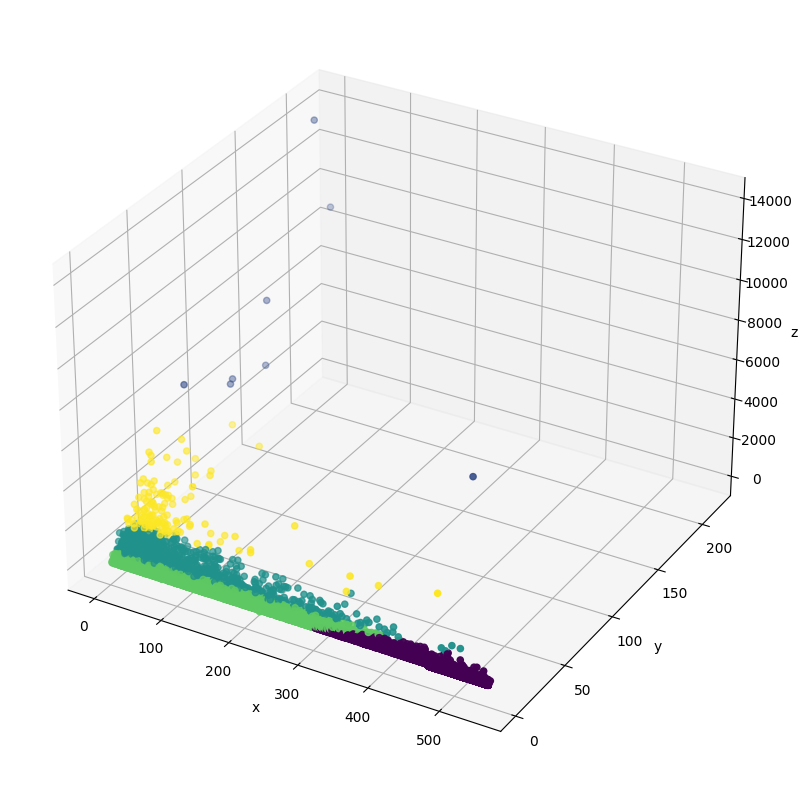

In [37]:
fig  = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df.x_scale, df.y_scale,df.z_scale,c=df.prediction)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [39]:
from pyspark.sql import functions as F
analysis = predictions\
    .groupBy('prediction')\
    .agg(F.round(avg('Recency'),2).alias('Avg Recency'),
         F.round(avg('Frequency'),2).alias('Avg Frequency'),
         F.round(avg('Monetary'),2).alias('Avg Monetary'),
         F.round(count('Monetary'),2).alias('Count'))
analysis.show()

+----------+-----------+-------------+------------+-----+
|prediction|Avg Recency|Avg Frequency|Avg Monetary|Count|
+----------+-----------+-------------+------------+-----+
|         1|      61.13|       131.88|     6947.56|    8|
|         3|     141.52|          4.1|      130.65| 6190|
|         4|      45.18|        31.22|     1720.51|  139|
|         2|      73.13|        12.02|      504.44| 1441|
|         0|     485.42|         1.37|       42.61|15724|
+----------+-----------+-------------+------------+-----+



In [ ]:
def cluster_function(prediction):
    if prediction ==0:
        return "Loyal"
    elif prediction ==1:
        return "Lost Cheap"
    elif prediction ==2:
        return "Big Spender"
    elif prediction ==3:
        return "Regular"
    return "Star"

cluster_function_udf = udf(cluster_function, StringType())
analysis=analysis.withColumn("type", cluster_function_udf(analysis['prediction']))
analysis.show()

### Nhận xét:

- Cluster 0(Loyal - KH có mức chi tiêu trung bình, tần suất mua hàng vừa phải): AVG Recency: 67.22, AVG Frequency: 13.83, AVG Monetary: 602.2

- Cluster 1(Lost Cheap - KH chi tiêu ít, tần suất mua hàng thấp, thời gian mua hàng xa - Không tiêu xài nhiều cho nhóm KH này): AVG Recency: 484.63, AVG Frequency: 1.37, AVG Monetary: 42.82
- Cluster 2(Big Spender - KH chi nhiều tiền và có tần suất mua hàng cao): AVG Recency: 50.81, AVG Frequency: 42.08, AVG Monetary: 2449.32
- Cluster 3(Regular - KH chi tiêu bình thường và có tần suất mua hàng tạm ổn): AVG Recency: 136.66, AVG Frequency: 4.36, AVG Monetary: 141.74
- Cluster 4(Star - KH mua gần đây, mua nhiều): AVG Recency: 2.0, AVG Frequency: 289.0, AVG Monetary: 9980.11